# How SGD Selects the Global Minima in Over-parameterized Learning: A Dynamical Stability Perspective

# Authors:  Lei Wu, Chao Ma, Weinan E

 - Presented by Skyhawks (Patrick Myers, Gaurav Jindal, Rishab Bamrara, Phillip Seaton)

 - Sources: we used some code from the official github repo for this paper (https://github.com/leiwu1990/sgd.stability)  

In [0]:
# Importing libraries
import time
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.datasets as dsets
import argparse
import json
import math
import os

DataLoader class represents a python iterable over the dataset. It helps us to read the dataset in chunks with dynamic batch size. It also shuffles the data for each epochs i.e. when the whole data read once. Input arguements are X, y and batch_size. It will return iterable batch_x, batch_y.

In [0]:
class DataLoader:

    def __init__(self,X,y,batch_size):
        self.X, self.y = X, y 
        self.batch_size = batch_size
        self.n_samples = len(y)
        self.idx = 0

    def __len__(self):
        return math.ceil(self.n_samples/self.batch_size)

    def __iter__(self):
        return self    

    def __next__(self):
        if self.idx >= self.n_samples:
            self.idx = 0
            rnd_idx = torch.randperm(self.n_samples)
            self.X = self.X[rnd_idx]
            self.y = self.y[rnd_idx]

        idx_end = min(self.idx+self.batch_size, self.n_samples)
        batch_X = self.X[self.idx:idx_end]
        batch_y = self.y[self.idx:idx_end]
        self.idx = idx_end

        return batch_X,batch_y

Performing one hot encoding on target label which basically convert categorical variables into binary vectors. Basically, each integer value in labels is converted into binary vector having all zero value except 1 at the index of the integer. Input size is [n_samples x 1] and output isze is [n_samples x n_classes].

In [0]:
def to_one_hot(labels):
    if labels.ndimension()==1:
        labels.unsqueeze_(1)
    n_samples = labels.shape[0]
    n_classes = labels.max()+1

    one_hot_labels = torch.FloatTensor(n_samples,n_classes)
    one_hot_labels.zero_()
    one_hot_labels.scatter_(1, labels, 1)

    return one_hot_labels

Downloading the FashionMNIST train and test dataset. Dataset have images with 28x28 in size and have 10 classes. Converting image pixel from 0-255 range to 0.0-1.0 range by diving it by 255. Converting train_y into one hot encoded labels. Output is train and test dataloader. 

In [0]:
def load_fmnist(training_size, batch_size=100):
    train_set = dsets.FashionMNIST('data/fashionmnist', train=True, download=True)
    train_X = train_set.data[0:training_size].float()/255
    train_y = to_one_hot(train_set.targets[0:training_size])
    train_loader = DataLoader(train_X, train_y, batch_size)

    test_set = dsets.FashionMNIST('data/fashionmnist', train=False,download=True)
    test_X  = test_set.data.float()/255
    test_y =  to_one_hot(test_set.targets)
    test_loader = DataLoader(test_X, test_y, batch_size)

    return train_loader, test_loader

Downloading the CIFAR10 train and test dataset. Dataset have images with 32x32 in size and have 10 classes but we have only considered two classes, "airplane" and "automobile". Converting image pixel from 0-255 range to 0.0-1.0 range by diving it by 255. Converting train_y into one hot encoded labels. Output is train and test dataloader. 

In [0]:
def load_cifar10(training_size, batch_size=100):
    train_set = dsets.CIFAR10('data/cifar10', train=True, download=True)
    train_X,train_y = modify_cifar_data(train_set.data, train_set.targets, training_size)
    train_loader = DataLoader(train_X, train_y, batch_size)

    test_set = dsets.CIFAR10('data/cifar10', train=False, download=True)
    test_X,test_y = modify_cifar_data(test_set.data, test_set.targets)
    test_loader = DataLoader(test_X, test_y, batch_size)

    return train_loader, test_loader

def modify_cifar_data(X, y, n_samples=-1):
    X = torch.from_numpy(X.transpose([0,3,1,2]))
    y = torch.LongTensor(y)

    X_t = torch.Tensor(50000,3,32,32)
    y_t = torch.LongTensor(50000)
    idx = 0
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1:
            y_t[idx] = y[i]
            X_t[idx,:,:,:] = X[i,:,:,:]
            idx += 1
    X = X_t[0:idx]
    y = y_t[0:idx] 

    if n_samples > 1:
        X = X[0:n_samples]
        y = y[0:n_samples]

    # preprocess the data
    X = X.float()/255.0
    y = to_one_hot(y) 

    return X, y

Showing an example of loading CIFAR 10 dataset and iterating train and test loader to get batch_x and batch_y.

In [6]:
train_loader, test_loader = load_cifar10(training_size=10000,batch_size=500)
print("Train loader")
for i in range(2):
    batch_x, batch_y = next(train_loader)
    print(i, batch_x.shape, batch_y.shape)
print("Test loader")
for i in range(2):
    batch_x, batch_y = next(test_loader)
    print(i, batch_x.shape, batch_y.shape)

0it [00:00, ?it/s]

100%|█████████▉| 170254336/170498071 [00:12<00:00, 17289509.43it/s]

Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified
Train loader
0 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
1 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
Test loader
0 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])
1 torch.Size([500, 3, 32, 32]) torch.Size([500, 2])


In [7]:
print(batch_x.shape)
print("One hot encoded Labels: ", batch_y[:5])
print("Image data: ", batch_x[0])

torch.Size([500, 3, 32, 32])
One hot encoded Labels:  tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
Image data:  tensor([[[0.5608, 0.5922, 0.6549,  ..., 0.4314, 0.5451, 0.4039],
         [0.8196, 0.8314, 0.8588,  ..., 0.4471, 0.4745, 0.5451],
         [0.8471, 0.7765, 0.7529,  ..., 0.5961, 0.5804, 0.6392],
         ...,
         [0.1294, 0.0941, 0.0784,  ..., 0.2902, 0.2745, 0.2667],
         [0.1451, 0.1216, 0.0980,  ..., 0.2784, 0.2745, 0.2627],
         [0.1608, 0.1490, 0.1294,  ..., 0.2667, 0.2667, 0.2588]],

        [[0.6275, 0.6549, 0.7137,  ..., 0.3333, 0.3686, 0.3020],
         [0.8510, 0.8706, 0.9059,  ..., 0.4510, 0.3216, 0.2627],
         [0.8941, 0.8314, 0.7961,  ..., 0.6039, 0.2706, 0.2431],
         ...,
         [0.1373, 0.1137, 0.0824,  ..., 0.2863, 0.2745, 0.2745],
         [0.1569, 0.1373, 0.1059,  ..., 0.2824, 0.2745, 0.2706],
         [0.1725, 0.1608, 0.1412,  ..., 0.2784, 0.2784, 0.2667]],

        [[0.7020, 0.7137, 0.75

Training models using pytorch. Serveral parameters are passed into the function: model (sgd), criterion (MSE Loss), dataloader (loading the training data), batch size of 1000 and 50000 iterations. We set all gradients of the model to zero, go through the batch gradient descent once with the given batch size. The avg_accuracy is changed by 10% of the minibatch each iteraiton. Every 200 iterations, we print iterations, loss, and accuracy.

In [0]:
def train(model, criterion, optimizer, dataloader, batch_size, n_iters=50000, verbose=True):
    model.train()
    acc_avg = 0  
    loss_avg = 0 
    since = time.time()
    for current_iter in range(n_iters):
        optimizer.zero_grad()
        loss,acc = compute_minibatch_GD(model, criterion, dataloader, batch_size)
        optimizer.step()
        if acc_avg > 0:
            acc_avg = 0.9 * acc_avg + 0.1 * acc
        else:
            acc_avg = acc
        if loss_avg > 0:
            loss_avg = 0.9 * loss_avg + 0.1 * loss
        else: 
            loss_avg = loss
        if current_iter%200 == 0:
            now = time.time()
            print('%d/%d, took %.0f seconds, train_loss: %.1e, train_acc: %.2f'%(
                    current_iter+1, n_iters, now-since, loss_avg, acc_avg))
            since = time.time()

Computing the minibatch gradient while iterating through the data from the data loader in increments of the batch size. Targets are the deisired outputs and logits are the predictions. Accuracy and lass are averaged across the batches.

In [0]:
def compute_minibatch_GD(model, criterion, dataloader, batch_size):
    loss = 0
    acc = 0
    n_loads = batch_size // dataloader.batch_size

    for i in range(n_loads):
        inputs, targets = next(dataloader)
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = model(inputs)
        E = criterion(logits,targets)
        E.backward()
        acc += accuracy(logits.data,targets)
        loss += E.item()
        
    for p in model.parameters():
        p.grad.data /= n_loads
    loss=loss/n_loads
    acc=acc/n_loads
    return loss, acc

We set the number of rows to n, which is the total number of targets/predictions. We compare the targets to the predictions and get the accuracy from the matches. 

In [0]:
def accuracy(logits, targets):
    n = logits.shape[0]
    if targets.ndimension() == 2:
        _, y_trues = torch.max(targets,1)
    else:
        y_trues = targets 
    _, y_preds = torch.max(logits,1)

    acc = (y_trues==y_preds).float().sum()
    acc=acc*100.0/n 
    return acc

In [0]:
def eval_accuracy(model, criterion, dataloader):
    model.eval()
    n_batchs = len(dataloader)
    dataloader.idx = 0

    loss_t, acc_t = 0.0, 0.0
    for i in range(n_batchs):
        inputs,targets = next(dataloader)
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = model(inputs)
        loss_t += criterion(logits,targets).item()
        acc_t += accuracy(logits.data,targets)

    return loss_t/n_batchs, acc_t/n_batchs

In [0]:
'''
Modified from https://github.com/pytorch/vision.git
'''


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features,feature_size=512,num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(feature_size, 128),
            nn.ReLU(True),
            nn.Linear(128,num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [16, 'M', 16, 'M', 32, 'M',  64, 'M', 64, 'M'],
    'A1': [16, 'M', 32, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M'],
    'A2': [32, 'M', 64, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256, 'M'],
    'A3': [64, 'M', 128, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'A4': [128, 'M', 256, 'M', 256, 256, 'M', 512, 512, 'M', 1024, 1024, 'M'],
    'B': [16, 16, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11(num_classes=10):
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']),feature_size=64,num_classes=num_classes)


def vgg11_big(num_classes=10):
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A3']),cfg['A3'][-2],num_classes)

def vgg11_bn(num_classes):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13(num_classes=10):
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']),num_classes)


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))


In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5,stride=1) # 28-5+1=24
        self.conv2 = nn.Conv2d(6,16,5,stride=1) # 12-5+1=8
        self.fc1 = nn.Linear(4*4*16,200)
        self.fc2 = nn.Linear(200,10)

    def forward(self,x):
        if x.ndimension()==3:
            x = x.unsqueeze(0)
        o = F.relu(self.conv1(x))
        o = F.avg_pool2d(o,2,2)

        o = F.relu(self.conv2(o))
        o = F.avg_pool2d(o,2,2)

        o = o.view(o.shape[0],-1)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        return o

class FNN(nn.Module):
    def __init__(self):
        super(FNN,self).__init__()
        self.net = nn.Sequential(nn.Linear(784,500),
                            nn.ReLU(),
                            nn.Linear(500,500),
                            nn.ReLU(),
                            nn.Linear(500,500),
                            nn.ReLU(),
                            nn.Linear(500,10))

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        o = self.net(x)
        return o

def lenet():
    return LeNet()

def fnn():
    return FNN()

Eigen variance function gives Sharpness and square root of eigen hessian function value gives Non uniformity.

In [0]:
#Returns Non-uniformity
def eigen_variance(net, criterion, dataloader, n_iters=10, tol=1e-2, verbose=False):         
    n_parameters = num_parameters(net)
    v0 = torch.randn(n_parameters)              #Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1

    Av_func = lambda v: variance_vec_prod(net, criterion, dataloader, v)
    mu = power_method(v0, Av_func, n_iters, tol, verbose)
    return mu

#Returns Sharpness
def eigen_hessian(net, criterion, dataloader, n_iters=10, tol=1e-2, verbose=False):          
    n_parameters = num_parameters(net)
    v0 = torch.randn(n_parameters)

    Av_func = lambda v: hessian_vec_prod(net, criterion, dataloader, v)
    mu = power_method(v0, Av_func, n_iters, tol, verbose)
    return mu


In [0]:
#Variance of vector product
def variance_vec_prod(net, criterion, dataloader, v):
    X, y = dataloader.X, dataloader.y
    Av, Hv, n_samples = 0, 0, len(y)

    for i in range(n_samples):
        bx, by = X[i:i+1].cuda(), y[i:i+1].cuda()   
        Hv_i = Hv_batch(net, criterion, bx, by, v)
        Av_i = Hv_batch(net, criterion, bx, by, Hv_i)
        Av += Av_i
        Hv += Hv_i
    Av /= n_samples                             #Averaging gradient of grdients
    Hv /= n_samples                             #Avering of gradients
    H2v = hessian_vec_prod(net, criterion, dataloader, Hv)
    return Av - H2v                             #(Av-H2v) = (E[X^2] - E[X]^2) is variance of vector product


#Hessian(Double derivative) of vector product
def hessian_vec_prod(net, criterion, dataloader, v):
    Hv_t = 0
    n_batchs = len(dataloader)
    dataloader.idx = 0
    for _ in range(n_batchs):
        bx, by = next(dataloader)
        Hv_t += Hv_batch(net, criterion, bx.cuda(), by.cuda(), v)

    return Hv_t/n_batchs

In [0]:
#Hessian vector multiplication for a batch
def Hv_batch(net, criterion, batch_x, batch_y, v):
    net.eval()
    logits = net(batch_x)
    loss = criterion(logits, batch_y)           #Evaluating the network and finding losses
    
    grads = autograd.grad(loss, net.parameters(), create_graph=True, retain_graph=True)
    idx, res = 0, 0
    
    for grad_i in grads:
        ng = torch.numel(grad_i)                #number of elements in grad_i which can be a matrix or a vector
        v_i = v[idx:idx+ng].cuda()    
        res += torch.dot(v_i, grad_i.view(-1))  #Dot product of a batch of v and grads [This is gradient vector multiplication]
        idx += ng                                      
    
    Hv = autograd.grad(res, net.parameters())   #This is the Hessian of gradient vaector multiplication
    Hv = [t.data.cpu().view(-1) for t in Hv]    #reshaping every tensor in Hv after bringing it to the cpu
    Hv = torch.cat(Hv)                          #concating the tensors along row. Hv becomes the same size/shape as vector v
    
    return Hv


#Helper function to find non-uniformity and sharpness. 
def power_method(v0, Av_func, n_iters=10, tol=1e-3, verbose=False):
    mu = 0                   
    v = v0/v0.norm()                            #Normalizing the vector by eucledian norm
    for i in range(n_iters):
        time_start = time.time()

        Av = Av_func(v)                         #Computing variance_vector_product for vector v
        mu_pre = mu            
        mu = torch.dot(Av,v).item()             #Computing dot product of 2 tensors (which is one value tensor) and then get the value inside that tensor
        v = Av/Av.norm()                        #Normalizing the vector by eucledian norm

        if abs(mu-mu_pre)/abs(mu) < tol:        #cheking for tolerance
            break
        if verbose:
            print('%d-th step takes %.0f seconds, \t %.2e'%(i+1,time.time()-time_start,mu))
            
    return mu


#Returns number of parameters of the entire network
def num_parameters(net):
    n_parameters = 0
    for para in net.parameters():
        n_parameters += para.data.numel()

    return n_parameters


In [0]:
# Setting Hyperparameters
gpuid = '0,'
dataset= 'fashionmnist'
n_samples = 1000
load_size = 1000
optimizer = 'sgd'
n_iters = 10000
batch_size = 1000
learning_rate = 1e-1
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

In [16]:
criterion = torch.nn.MSELoss().cuda()

if dataset == 'fashionmnist':
        train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=load_size)
        net = fnn().cuda()
        
elif dataset == 'cifar10':
        train_loader, test_loader = load_cifar10(training_size=n_samples, batch_size=load_size)
        net = vgg11(num_classes=2).cuda()

if optimizer == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
elif optimizer == 'adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

print(optimizer)

print('===> Architecture:')
print(net)

print('===> Start training')
train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=True)

train_loss, train_accuracy = eval_accuracy(net, criterion, train_loader)
test_loss, test_accuracy = eval_accuracy(net, criterion, test_loader)
print('===> Solution: ')
print('\t train loss: %.2e, acc: %.2f' % (train_loss, train_accuracy))
print('\t test loss: %.2e, acc: %.2f' % (test_loss, test_accuracy))


0it [00:00, ?it/s]


100%|█████████▉| 26361856/26421880 [00:05<00:00, 5761499.72it/s]

Extracting data/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/fashionmnist/FashionMNIST/raw




0it [00:00, ?it/s]



  0%|          | 0/29515 [00:00<?, ?it/s]

 56%|█████▌    | 16384/29515 [00:00<00:00, 62629.85it/s]

32768it [00:00, 39448.01it/s]                           

0it [00:00, ?it/s]

Extracting data/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/fashionmnist/FashionMNIST/raw




  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:00<01:10, 62679.95it/s]

  1%|          | 49152/4422102 [00:01<00:59, 73714.82it/s]

  2%|▏         | 106496/4422102 [00:01<00:46, 92031.24it/s]

  5%|▌         | 229376/4422102 [00:01<00:34, 121281.58it/s]

  9%|▉         | 417792/4422102 [00:01<00:24, 161584.64it/s]

 19%|█▉        | 851968/4422102 [00:02<00:16, 221576.79it/s]

 39%|███▉      | 1720320/4422102 [00:02<00:08, 307725.34it/s]

 78%|███████▊  | 3448832/4422102 [00:02<00:02, 430992.38it/s]

4423680it [00:02, 1626588.89it/s]                            

0it [00:00, ?it/s]

Extracting data/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/fashionmnist/FashionMNIST/raw




  0%|          | 0/5148 [00:00<?, ?it/s]

8192it [00:00, 14549.93it/s]            

Extracting data/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/fashionmnist/FashionMNIST/raw
Processing...
Done!


170500096it [00:30, 17289509.43it/s]                               

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
===> Architecture:
FNN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=10, bias=True)
  )
)
===> Start training
1/10000, took 0 seconds, train_loss: 1.0e-01, train_acc: 9.20
201/10000, took 1 seconds, train_loss: 6.9e-02, train_acc: 55.69
401/10000, took 1 seconds, train_loss: 5.3e-02, train_acc: 65.56
601/10000, took 1 seconds, train_loss: 4.4e-02, train_acc: 72.41
801/10000, took 1 seconds, train_loss: 3.9e-02, train_acc: 75.93
1001/10000, took 1 seconds, train_loss: 3.6e-02, train_acc: 78.43
1201/10000, took 1 seconds, train_loss: 3.3e-02, train_acc: 80.87
1401/10000, took 1 seconds, train_loss: 3.1e-02, train_acc: 82.59
1


26427392it [00:22, 5761499.72it/s]                              

2001/10000, took 1 seconds, train_loss: 2.5e-02, train_acc: 88.42
2201/10000, took 1 seconds, train_loss: 2.3e-02, train_acc: 89.30
2401/10000, took 1 seconds, train_loss: 2.2e-02, train_acc: 90.38
2601/10000, took 1 seconds, train_loss: 2.1e-02, train_acc: 90.79
2801/10000, took 1 seconds, train_loss: 1.9e-02, train_acc: 91.87
3001/10000, took 1 seconds, train_loss: 1.8e-02, train_acc: 92.47
3201/10000, took 1 seconds, train_loss: 1.7e-02, train_acc: 93.50
3401/10000, took 1 seconds, train_loss: 1.6e-02, train_acc: 94.06
3601/10000, took 1 seconds, train_loss: 1.6e-02, train_acc: 95.04
3801/10000, took 1 seconds, train_loss: 1.5e-02, train_acc: 95.62
4001/10000, took 1 seconds, train_loss: 1.4e-02, train_acc: 96.09
4201/10000, took 1 seconds, train_loss: 1.4e-02, train_acc: 96.39
4401/10000, took 1 seconds, train_loss: 1.3e-02, train_acc: 96.73
4601/10000, took 1 seconds, train_loss: 1.2e-02, train_acc: 97.21
4801/10000, took 1 seconds, train_loss: 1.2e-02, train_acc: 97.44
5001/10000

In [17]:
print('===> Compute sharpness:')
sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=False)
print('Sharpness is %.2e\n'%(sharpness))

print('===> Compute non-uniformity:')
non_uniformity = math.sqrt(eigen_variance(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True))
print('Non-uniformity is %.2e\n'%(non_uniformity))

===> Compute sharpness:
Sharpness is 1.84e+01

===> Compute non-uniformity:
1-th step takes 15 seconds, 	 1.23e-02
2-th step takes 15 seconds, 	 9.97e+02
3-th step takes 15 seconds, 	 1.20e+03
4-th step takes 15 seconds, 	 1.32e+03
5-th step takes 15 seconds, 	 1.38e+03
6-th step takes 15 seconds, 	 1.40e+03
7-th step takes 15 seconds, 	 1.40e+03
8-th step takes 15 seconds, 	 1.40e+03
9-th step takes 15 seconds, 	 1.40e+03
10-th step takes 15 seconds, 	 1.41e+03
Non-uniformity is 3.75e+01



In [0]:
# Setting Hyperparameters
gpuid = '0,'
dataset= 'cifar10'
n_samples = 1000
load_size = 1000
optimizer = 'sgd'
n_iters = 2000
batch_size = 1000
learning_rate = 1e-1
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

In [19]:
criterion = torch.nn.MSELoss().cuda()

if dataset == 'fashionmnist':
        train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=load_size)
        net = fnn().cuda()
        
elif dataset == 'cifar10':
        train_loader, test_loader = load_cifar10(training_size=n_samples, batch_size=load_size)
        net = vgg11(num_classes=2).cuda()

if optimizer == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
elif optimizer == 'adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

print(optimizer)

print('===> Architecture:')
print(net)

print('===> Start training')
train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=True)

train_loss, train_accuracy = eval_accuracy(net, criterion, train_loader)
test_loss, test_accuracy = eval_accuracy(net, criterion, test_loader)
print('===> Solution: ')
print('\t train loss: %.2e, acc: %.2f' % (train_loss, train_accuracy))
print('\t test loss: %.2e, acc: %.2f' % (test_loss, test_accuracy))

Files already downloaded and verified
Files already downloaded and verified
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
===> Architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Co

In [20]:
print('===> Compute sharpness:')
sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=False)
print('Sharpness is %.2e\n'%(sharpness))

print('===> Compute non-uniformity:')
non_uniformity = math.sqrt(eigen_variance(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True))
print('Non-uniformity is %.2e\n'%(non_uniformity))

===> Compute sharpness:
Sharpness is 1.92e+01

===> Compute non-uniformity:
1-th step takes 20 seconds, 	 1.46e-01
2-th step takes 20 seconds, 	 2.25e+03
3-th step takes 20 seconds, 	 2.76e+03
4-th step takes 20 seconds, 	 2.80e+03
5-th step takes 20 seconds, 	 2.81e+03
6-th step takes 20 seconds, 	 2.81e+03
Non-uniformity is 5.30e+01



## **Experimental Results**

In [0]:
# Setting Hyperparameters
gpuid = '0,'
dataset= 'fashionmnist'
n_samples = 1000
optimizer = 'sgd'
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid


train_accuracies_list = []
test_accuracies_list = []
sharpnesses_list = []

# [lr, batch_size]
configs = [
    [0.1, 10],
    [0.1, 400],
    [0.3, 1000],
    [0.5, 1000],
]

n_iters=50
total_iters=3000

for config in configs:
    learning_rate = config[0]
    batch_size = config[1]
    
    criterion = torch.nn.MSELoss().cuda()
    
    train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=batch_size)
    net = fnn().cuda()   
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    
    train_accuracies = []
    test_accuracies = []
    sharpnesses = []
    
    for i in range(total_iters//n_iters):
        
        print(i*n_iters)
        train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=False)

        train_loss, train_accuracy = eval_accuracy(net, criterion, train_loader)
        test_loss, test_accuracy = eval_accuracy(net, criterion, test_loader)
        sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=False)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        sharpnesses.append(sharpness)


        print("trn", train_loss, train_accuracy)
        print("tst", test_loss, test_accuracy)
        print("sharpness", sharpness)

        
    train_accuracies_list.append(train_accuracies)
    test_accuracies_list.append(test_accuracies)
    sharpnesses_list.append(sharpnesses)

0
1/50, took 0 seconds, train_loss: 1.0e-01, train_acc: 0.00
trn 0.08573474995791912 tensor(34.3000, device='cuda:0')
tst 0.08584416523575783 tensor(34.5300, device='cuda:0')
sharpness 0.5531548261642456
50
1/50, took 0 seconds, train_loss: 8.3e-02, train_acc: 60.00
trn 0.08027664467692375 tensor(50.9000, device='cuda:0')
tst 0.08073017945140601 tensor(48.4500, device='cuda:0')
sharpness 0.7406520843505859
100
1/50, took 0 seconds, train_loss: 8.2e-02, train_acc: 40.00
trn 0.0749057675153017 tensor(58.7000, device='cuda:0')
tst 0.07551896268874407 tensor(55.3500, device='cuda:0')
sharpness 0.95672607421875
150
1/50, took 0 seconds, train_loss: 7.7e-02, train_acc: 50.00
trn 0.06956494521349668 tensor(55.3000, device='cuda:0')
tst 0.07065660105273128 tensor(52.5300, device='cuda:0')
sharpness 1.1368587017059326
200
1/50, took 0 seconds, train_loss: 6.9e-02, train_acc: 50.00
trn 0.06567363306879997 tensor(59.6000, device='cuda:0')
tst 0.0667425533272326 tensor(56.6400, device='cuda:0')
sh

# Sharpness, Training Accuracy and Test Accuracy vs Iterations
Here we compare sharpness, training accuracy, and testing accuracy on the FashionMNIST dataset. To better show the escape process, we only show the first 3000 iterations. Lower sharpness results on more stable global minima and higher test accuracy. The trials with higher sharpness take longer to escape an unstable minima. 


[tensor(34.3000, device='cuda:0'), tensor(50.9000, device='cuda:0'), tensor(58.7000, device='cuda:0'), tensor(55.3000, device='cuda:0'), tensor(59.6000, device='cuda:0'), tensor(58.6000, device='cuda:0'), tensor(60.3000, device='cuda:0'), tensor(65.1000, device='cuda:0'), tensor(61.2000, device='cuda:0'), tensor(65.4000, device='cuda:0'), tensor(67.2000, device='cuda:0'), tensor(70.3000, device='cuda:0'), tensor(72.2000, device='cuda:0'), tensor(71.9000, device='cuda:0'), tensor(73.5000, device='cuda:0'), tensor(74.2000, device='cuda:0'), tensor(73.7000, device='cuda:0'), tensor(75.7000, device='cuda:0'), tensor(78., device='cuda:0'), tensor(76., device='cuda:0'), tensor(76.6000, device='cuda:0'), tensor(78.8000, device='cuda:0'), tensor(77.7000, device='cuda:0'), tensor(78.8000, device='cuda:0'), tensor(78.8000, device='cuda:0'), tensor(79.7000, device='cuda:0'), tensor(80.9000, device='cuda:0'), tensor(81.5000, device='cuda:0'), tensor(81.3000, device='cuda:0'), tensor(82.3000, devic

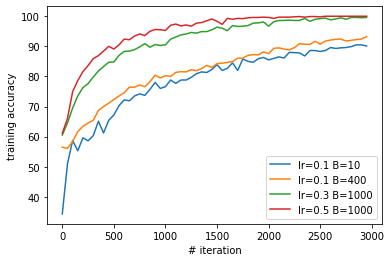

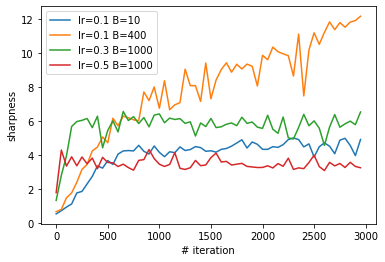

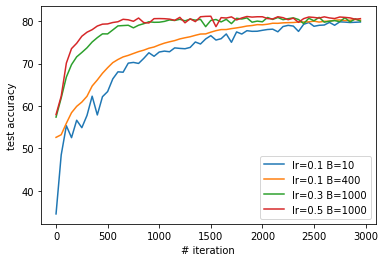

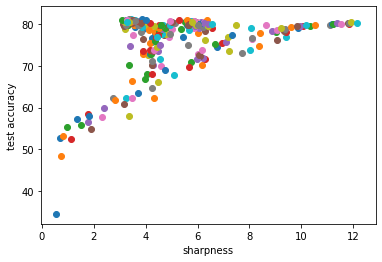

In [0]:
# Prediction of escape: (a) FashionMNIST
import matplotlib.pyplot as plt

iterations = [i for i in range(0, total_iters, n_iters)]

print(train_accuracies_list[0])

# training
for i in range(len(train_accuracies_list)):
    plt.plot(iterations, train_accuracies_list[i], label="lr=" + str(configs[i][0]) + " B=" + str(configs[i][1]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("training accuracy")
plt.show()

# sharpness
for i in range(len(sharpnesses_list)):
    plt.plot(iterations, sharpnesses_list[i], label="lr=" + str(configs[i][0]) + " B=" + str(configs[i][1]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("sharpness")
plt.show()

# testing
for i in range(len(test_accuracies_list)):
    plt.plot(iterations, test_accuracies_list[i], label="lr=" + str(configs[i][0]) + " B=" + str(configs[i][1]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("test accuracy")
plt.show()

# sharpness vs testing
for i in range(len(sharpnesses_list)):
    for j in range(len(sharpnesses_list[i])):
        plt.scatter(sharpnesses_list[i][j], test_accuracies_list[i][j].cpu())
plt.xlabel("sharpness")
plt.ylabel("test accuracy")
plt.show()

In [0]:
# GD Vs SGD Plot: Quasi-Newton methods

# Setting Hyperparameters
gpuid = '0,'
dataset= 'fashionmnist'
n_samples = 1000
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid


train_accuracies_list = []
test_accuracies_list = []
sharpnesses_list = []

# [lr, batch_size]
configs = [
    ['gd',0.8, 1000],
    ['sgd',0.4, 4]
]

n_iters=100
total_iters=5000

for config in configs:
    learning_rate = config[1]
    batch_size = config[2]
    
    criterion = torch.nn.MSELoss().cuda()
    
    train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=batch_size)
    net = fnn().cuda()   
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    
    train_accuracies = []
    test_accuracies = []
    sharpnesses = []
    
    for i in range(total_iters//n_iters):
        
        print(i*n_iters)
        train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=False)

        train_loss, train_accuracy = eval_accuracy(net, criterion, train_loader)
        test_loss, test_accuracy = eval_accuracy(net, criterion, test_loader)
        sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=False)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        sharpnesses.append(sharpness)


        print("trn", train_loss, train_accuracy)
        print("tst", test_loss, test_accuracy)
        print("sharpness", sharpness)

        
    train_accuracies_list.append(train_accuracies)
    test_accuracies_list.append(test_accuracies)
    sharpnesses_list.append(sharpnesses)

0
1/50, took 0 seconds, train_loss: 1.0e-01, train_acc: 10.00
trn 0.08105339109897614 tensor(39.5000, device='cuda:0')
tst 0.08404994830489158 tensor(36.4000, device='cuda:0')
sharpness 3.074007511138916
50
1/50, took 0 seconds, train_loss: 8.1e-02, train_acc: 39.50
trn 0.04394197091460228 tensor(72.3000, device='cuda:0')
tst 0.04758591093122959 tensor(70.0100, device='cuda:0')
sharpness 2.751638412475586
100
1/50, took 0 seconds, train_loss: 4.4e-02, train_acc: 72.30
trn 0.03517616540193558 tensor(79.5000, device='cuda:0')
tst 0.04058508574962616 tensor(73.7900, device='cuda:0')
sharpness 2.1138627529144287
150
1/50, took 0 seconds, train_loss: 3.5e-02, train_acc: 79.50
trn 0.030869781970977783 tensor(82.9000, device='cuda:0')
tst 0.03769529573619366 tensor(76.0200, device='cuda:0')
sharpness 2.126957416534424
200
1/50, took 0 seconds, train_loss: 3.1e-02, train_acc: 82.90
trn 0.026904147118330002 tensor(85.1000, device='cuda:0')
tst 0.03561539798974991 tensor(77.4800, device='cuda:0'

# Comparing GD and SGD Performance

Here we compare Gradient Descent and Stochastic Gradient Descent on the FashionMNIST dataset. Compared to normal SGD, adaptive optimizers perform worse, because they chose sharper minimizers. Higher sharpness causes less stability. We see GD perform much better in the training accuracy but is only marginally better on the test accuracy.  



[tensor(39.5000, device='cuda:0'), tensor(72.3000, device='cuda:0'), tensor(79.5000, device='cuda:0'), tensor(82.9000, device='cuda:0'), tensor(85.1000, device='cuda:0'), tensor(86.5000, device='cuda:0'), tensor(89.0000, device='cuda:0'), tensor(89.8000, device='cuda:0'), tensor(91.6000, device='cuda:0'), tensor(91.3000, device='cuda:0'), tensor(93.2000, device='cuda:0'), tensor(92.4000, device='cuda:0'), tensor(95.0000, device='cuda:0'), tensor(94.8000, device='cuda:0'), tensor(95.8000, device='cuda:0'), tensor(96.5000, device='cuda:0'), tensor(97.3000, device='cuda:0'), tensor(96.5000, device='cuda:0'), tensor(97.6000, device='cuda:0'), tensor(97.9000, device='cuda:0'), tensor(99.0000, device='cuda:0'), tensor(97.7000, device='cuda:0'), tensor(99.1000, device='cuda:0'), tensor(98.3000, device='cuda:0'), tensor(98.7000, device='cuda:0'), tensor(98.6000, device='cuda:0'), tensor(99.4000, device='cuda:0'), tensor(98.7000, device='cuda:0'), tensor(99.1000, device='cuda:0'), tensor(99.500

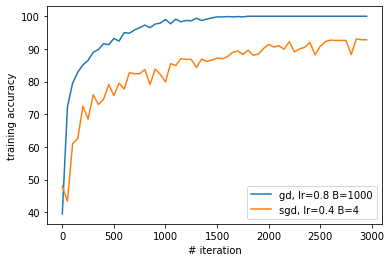

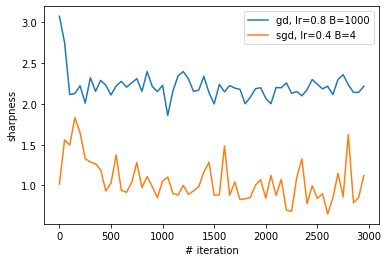

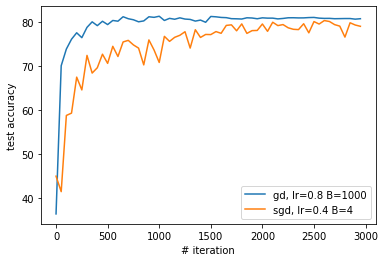

In [0]:
import matplotlib.pyplot as plt

iterations = [i for i in range(0, total_iters, n_iters)]

print(train_accuracies_list[0])

# training
for i in range(len(train_accuracies_list)):
    plt.plot(iterations, train_accuracies_list[i], label= str(configs[i][0]) + ", lr=" + str(configs[i][1]) + " B=" + str(configs[i][2]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("training accuracy")
plt.show()

# sharpness
for i in range(len(sharpnesses_list)):
    plt.plot(iterations, sharpnesses_list[i], label= str(configs[i][0]) + ", lr=" + str(configs[i][1]) + " B=" + str(configs[i][2]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("sharpness")
plt.show()

# testing
for i in range(len(test_accuracies_list)):
    plt.plot(iterations, test_accuracies_list[i], label= str(configs[i][0]) + ", lr=" + str(configs[i][1]) + " B=" + str(configs[i][2]))
plt.legend()
plt.xlabel("# iteration")
plt.ylabel("test accuracy")
plt.show()


In [0]:
# Non-uniformity vs Sharpness
gpuid = '0,'
dataset= 'fashionmnist'
n_samples = 1000
optimizer = 'sgd'
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid
n_iters=10000


sharpnesses_list = []
nonuniformities_list = []

# [lr, batch_size]
configs = [
    [0.1, 1000],
    [0.1, 25],
    [0.1, 10],
    [0.1, 4],
]


for config in configs:
  sharpnesses = []
  nonuniformities = []
  
  for i in range(4):
      learning_rate = config[0]
      batch_size = config[1]
      
      criterion = torch.nn.MSELoss().cuda()
      
      train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=batch_size)
      net = fnn().cuda()   
      
      optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
      
      train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=False)
      print("sharpness")
      sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True)
      print("nonuniformity")
      non_uniformity = math.sqrt(eigen_variance(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True))

      print("sharpness", sharpness)
      print("nonuniformity", non_uniformity)

      sharpnesses.append(sharpness)
      nonuniformities.append(non_uniformity)

    
  sharpnesses_list.append(sharpnesses)
  nonuniformities_list.append(nonuniformities)


1/10000, took 0 seconds, train_loss: 9.8e-02, train_acc: 9.50
201/10000, took 2 seconds, train_loss: 6.8e-02, train_acc: 60.91
401/10000, took 2 seconds, train_loss: 5.3e-02, train_acc: 65.66
601/10000, took 2 seconds, train_loss: 4.5e-02, train_acc: 72.67
801/10000, took 2 seconds, train_loss: 4.0e-02, train_acc: 75.42
1001/10000, took 2 seconds, train_loss: 3.6e-02, train_acc: 79.04
1201/10000, took 2 seconds, train_loss: 3.3e-02, train_acc: 81.23
1401/10000, took 2 seconds, train_loss: 3.1e-02, train_acc: 82.86
1601/10000, took 2 seconds, train_loss: 2.8e-02, train_acc: 84.78
1801/10000, took 2 seconds, train_loss: 2.7e-02, train_acc: 86.88
2001/10000, took 2 seconds, train_loss: 2.5e-02, train_acc: 88.37
2201/10000, took 2 seconds, train_loss: 2.3e-02, train_acc: 89.55
2401/10000, took 2 seconds, train_loss: 2.2e-02, train_acc: 90.29
2601/10000, took 2 seconds, train_loss: 2.1e-02, train_acc: 91.48
2801/10000, took 2 seconds, train_loss: 2.0e-02, train_acc: 92.70
3001/10000, took 2

6-th step takes 35 seconds, 	 1.60e+03
7-th step takes 35 seconds, 	 1.60e+03
8-th step takes 35 seconds, 	 1.61e+03
9-th step takes 34 seconds, 	 1.61e+03
10-th step takes 34 seconds, 	 1.61e+03
sharpness 18.832305908203125
nonuniformity 40.09451267055209
1/10000, took 0 seconds, train_loss: 1.0e-01, train_acc: 8.00
201/10000, took 1 seconds, train_loss: 6.8e-02, train_acc: 59.13
401/10000, took 1 seconds, train_loss: 5.3e-02, train_acc: 63.35
601/10000, took 1 seconds, train_loss: 4.4e-02, train_acc: 73.71
801/10000, took 1 seconds, train_loss: 4.1e-02, train_acc: 75.86
1001/10000, took 1 seconds, train_loss: 3.7e-02, train_acc: 79.66
1201/10000, took 1 seconds, train_loss: 3.3e-02, train_acc: 81.95
1401/10000, took 1 seconds, train_loss: 3.2e-02, train_acc: 80.32
1601/10000, took 1 seconds, train_loss: 3.0e-02, train_acc: 83.47
1801/10000, took 1 seconds, train_loss: 2.8e-02, train_acc: 85.34
2001/10000, took 1 seconds, train_loss: 2.7e-02, train_acc: 86.77
2201/10000, took 1 second

5-th step takes 35 seconds, 	 7.81e+02
6-th step takes 35 seconds, 	 7.96e+02
7-th step takes 35 seconds, 	 8.04e+02
8-th step takes 35 seconds, 	 8.08e+02
9-th step takes 35 seconds, 	 8.09e+02
10-th step takes 35 seconds, 	 8.10e+02
sharpness 9.75965690612793
nonuniformity 28.464382468902034
1/10000, took 0 seconds, train_loss: 1.0e-01, train_acc: 0.00
201/10000, took 1 seconds, train_loss: 6.9e-02, train_acc: 61.73
401/10000, took 1 seconds, train_loss: 5.4e-02, train_acc: 70.95
601/10000, took 1 seconds, train_loss: 4.2e-02, train_acc: 71.75
801/10000, took 1 seconds, train_loss: 3.8e-02, train_acc: 78.61
1001/10000, took 1 seconds, train_loss: 4.1e-02, train_acc: 73.03
1201/10000, took 1 seconds, train_loss: 3.4e-02, train_acc: 82.43
1401/10000, took 1 seconds, train_loss: 2.5e-02, train_acc: 89.67
1601/10000, took 1 seconds, train_loss: 2.8e-02, train_acc: 83.86
1801/10000, took 1 seconds, train_loss: 2.8e-02, train_acc: 83.90
2001/10000, took 1 seconds, train_loss: 2.5e-02, trai

2-th step takes 41 seconds, 	 1.86e+02
3-th step takes 40 seconds, 	 2.24e+02
4-th step takes 38 seconds, 	 2.42e+02
5-th step takes 38 seconds, 	 2.52e+02
6-th step takes 38 seconds, 	 2.57e+02
7-th step takes 40 seconds, 	 2.60e+02
8-th step takes 39 seconds, 	 2.61e+02
9-th step takes 39 seconds, 	 2.62e+02
10-th step takes 39 seconds, 	 2.62e+02
sharpness 7.30197811126709
nonuniformity 16.182284542295395
1/10000, took 0 seconds, train_loss: 9.5e-02, train_acc: 50.00
201/10000, took 1 seconds, train_loss: 7.2e-02, train_acc: 58.45
401/10000, took 1 seconds, train_loss: 6.2e-02, train_acc: 57.30
601/10000, took 1 seconds, train_loss: 5.0e-02, train_acc: 61.05
801/10000, took 1 seconds, train_loss: 4.0e-02, train_acc: 77.98
1001/10000, took 1 seconds, train_loss: 4.2e-02, train_acc: 74.34
1201/10000, took 1 seconds, train_loss: 3.8e-02, train_acc: 76.39
1401/10000, took 1 seconds, train_loss: 3.2e-02, train_acc: 80.85
1601/10000, took 1 seconds, train_loss: 3.5e-02, train_acc: 78.40
1

6-th step takes 5 seconds, 	 2.90e+00
7-th step takes 5 seconds, 	 2.95e+00
8-th step takes 5 seconds, 	 2.98e+00
9-th step takes 5 seconds, 	 3.00e+00
10-th step takes 4 seconds, 	 3.00e+00
nonuniformity
1-th step takes 42 seconds, 	 7.70e-04
2-th step takes 44 seconds, 	 4.14e+01
3-th step takes 41 seconds, 	 5.02e+01
4-th step takes 41 seconds, 	 5.68e+01
5-th step takes 42 seconds, 	 6.24e+01
6-th step takes 43 seconds, 	 6.60e+01
7-th step takes 42 seconds, 	 6.80e+01
8-th step takes 41 seconds, 	 6.89e+01
9-th step takes 42 seconds, 	 6.93e+01
10-th step takes 41 seconds, 	 6.95e+01
sharpness 3.004318952560425
nonuniformity 8.33853409286495


# Non-uniformity vs Sharpness 

Here we use the FashionMNIST dataset to compare the relationship between sharpness and non-uniformity. As in the paper, our results show that there is a positive relationship between sharpness and nonuniformity. Models with higher sharpness will result in higher nonuniformity. Larger batch sizes cause the non-uniformity to be close to the upper bounds.


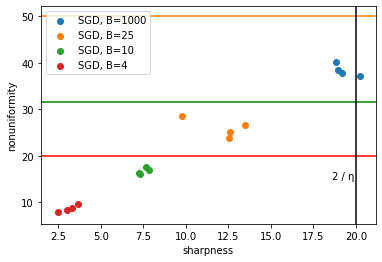

In [0]:
import matplotlib.pyplot as plt

for i in range(len(sharpnesses_list)):
  sc = plt.scatter(sharpnesses_list[i], nonuniformities_list[i], label= "SGD, B=" + str(configs[i][1]))  

plt.axhline(math.sqrt(configs[1][1])/0.1, color = '#ff7f0e')
plt.axhline(math.sqrt(configs[2][1])/0.1, color = 'g')
plt.axhline(math.sqrt(configs[3][1])/0.1, color = 'r')

plt.axvline(x=2/0.1, color='k')
plt.text(18.6, 15, '2 / \u03B7')
plt.xlabel("sharpness")
plt.ylabel("nonuniformity")
plt.legend(loc='upper left')
plt.show()

In [0]:
# Non-uniformity vs batch size
import numpy as np
gpuid = '0,'
dataset= 'fashionmnist'
n_samples = 1000
optimizer = 'sgd'
momentum = 0.0
os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

n_iters=10000

sharpnesses_list = []
nonuniformities_list = []

# [lr, batch_size]
configs = [
    [0.05, 10],
    [0.05, 100],
    [0.05, 1000],
    [0.1, 10],
    [0.1, 100],
    [0.1, 1000],
    [0.5, 10],
    [0.5, 100],
    [0.5, 1000],
]


for config in configs:
    learning_rate = config[0]
    batch_size = config[1]
    
    criterion = torch.nn.MSELoss().cuda()
    
    train_loader, test_loader = load_fmnist(training_size=n_samples, batch_size=batch_size)
    net = fnn().cuda()   
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    
    train(net, criterion, optimizer, train_loader, batch_size, n_iters, verbose=False)
    print("sharpness")
    sharpness = eigen_hessian(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True)
    print("nonuniformity")
    non_uniformity = math.sqrt(eigen_variance(net, criterion, train_loader, n_iters=10, tol=1e-4, verbose=True))

    print("sharpness", sharpness)
    print("nonuniformity", non_uniformity)

    
    sharpnesses_list.append(sharpness)
    nonuniformities_list.append(non_uniformity)

1/10000, took 0 seconds, train_loss: 1.1e-01, train_acc: 0.00
201/10000, took 1 seconds, train_loss: 7.9e-02, train_acc: 52.64
401/10000, took 1 seconds, train_loss: 6.9e-02, train_acc: 55.28
601/10000, took 1 seconds, train_loss: 6.1e-02, train_acc: 60.61
801/10000, took 1 seconds, train_loss: 5.3e-02, train_acc: 64.82
1001/10000, took 1 seconds, train_loss: 4.7e-02, train_acc: 74.59
1201/10000, took 1 seconds, train_loss: 4.7e-02, train_acc: 71.06
1401/10000, took 1 seconds, train_loss: 3.9e-02, train_acc: 78.68
1601/10000, took 1 seconds, train_loss: 4.0e-02, train_acc: 74.89
1801/10000, took 1 seconds, train_loss: 4.1e-02, train_acc: 72.25
2001/10000, took 1 seconds, train_loss: 4.0e-02, train_acc: 73.49
2201/10000, took 1 seconds, train_loss: 3.4e-02, train_acc: 81.93
2401/10000, took 1 seconds, train_loss: 3.8e-02, train_acc: 76.93
2601/10000, took 1 seconds, train_loss: 3.4e-02, train_acc: 80.16
2801/10000, took 1 seconds, train_loss: 3.3e-02, train_acc: 82.31
3001/10000, took 1

# Non-uniformity and Sharpness vs Batch Size

Here we examine the affect of varying batch size on sharpness and non-uniformity. Because we have 1000 samples, the rightmost points (batch size = 1000) corresponds to GD. As batch size increases, sharpness and non-uniformity tend to increase as well. Smaller batch sizes lead to flatter solutions. Lower learning rates tend to result in higher sharpness and non-uniformity.

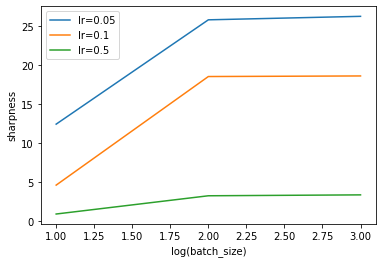

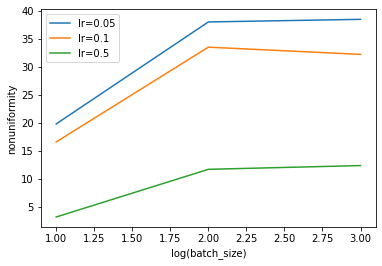

In [0]:
import matplotlib.pyplot as plt

batch_size = [1, 2, 3]
lr = [0.05, 0.10, 0.50]


# batch size vs sharpness
for i in range(3):
    start = i*3
    end = start+3
    plt.scatter(batch_size, sharpnesses_list[start:end])
    plt.plot(batch_size, sharpnesses_list[start:end], label="lr=" + str(lr[i]))
plt.legend()
plt.xlabel("log(batch size)")
plt.ylabel("sharpness")
plt.show()

# batch size vs nonuniformity
for i in range(3):
    start = i*3
    end = start+3
    plt.scatter(batch_size, nonuniformities_list[start:end])
    plt.plot(batch_size, nonuniformities_list[start:end], label="lr=" + str(lr[i]))
plt.legend()
plt.xlabel("log(batch size)")
plt.ylabel("nonuniformity")
plt.show()